In [18]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16 # type: ignore
from tensorflow.keras import layers, models # type: ignore

# ==========================
# 1. Pisahkan Data Train dan Test
# ==========================
DATASET_PATH = r"C:\JUAN KUGANDA\UASKB\dataset"  # Path ke folder dataset utama
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
TEST_PATH = os.path.join(DATASET_PATH, "test")

# Buat folder train dan test jika belum ada
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(TEST_PATH, exist_ok=True)

# Loop untuk membagi dataset secara otomatis
for person in os.listdir(DATASET_PATH):
    person_path = os.path.join(DATASET_PATH, person)

    # Hanya proses folder teman, bukan train/test
    if os.path.isdir(person_path) and person not in ["train", "test"]:
        images = os.listdir(person_path)

        # Filter hanya file yang valid
        images = [img for img in images if os.path.isfile(os.path.join(person_path, img))]

        # Cek apakah folder memiliki file
        if len(images) == 0:
            print(f"Folder kosong, dilewati: {person_path}")
            continue  # Lewati folder kosong

        # Bagi data menjadi train (80%) dan test (20%)
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
        
        # Buat folder teman di dalam train dan test
        os.makedirs(os.path.join(TRAIN_PATH, person), exist_ok=True)
        os.makedirs(os.path.join(TEST_PATH, person), exist_ok=True)

        # Salin gambar ke folder train
        for img in train_images:
            src_path = os.path.join(person_path, img)
            dst_path = os.path.join(TRAIN_PATH, person, img)
            try:
                shutil.copy(src_path, dst_path)
                print(f"Train: {src_path} -> {dst_path}")
            except PermissionError as e:
                print(f"Permission denied: {src_path} - {e}")

        # Salin gambar ke folder test
        for img in test_images:
            src_path = os.path.join(person_path, img)
            dst_path = os.path.join(TEST_PATH, person, img)
            try:
                shutil.copy(src_path, dst_path)
                print(f"Test: {src_path} -> {dst_path}")
            except PermissionError as e:
                print(f"Permission denied: {src_path} - {e}")

print("Proses pemisahan gambar selesai!")

Train: C:\JUAN KUGANDA\UASKB\dataset\Ahmad Mujahid\muje8.jpg -> C:\JUAN KUGANDA\UASKB\dataset\train\Ahmad Mujahid\muje8.jpg
Train: C:\JUAN KUGANDA\UASKB\dataset\Ahmad Mujahid\muje14.jpg -> C:\JUAN KUGANDA\UASKB\dataset\train\Ahmad Mujahid\muje14.jpg
Train: C:\JUAN KUGANDA\UASKB\dataset\Ahmad Mujahid\muje3.jpg -> C:\JUAN KUGANDA\UASKB\dataset\train\Ahmad Mujahid\muje3.jpg
Train: C:\JUAN KUGANDA\UASKB\dataset\Ahmad Mujahid\muje11.jpg -> C:\JUAN KUGANDA\UASKB\dataset\train\Ahmad Mujahid\muje11.jpg
Train: C:\JUAN KUGANDA\UASKB\dataset\Ahmad Mujahid\muje10.jpg -> C:\JUAN KUGANDA\UASKB\dataset\train\Ahmad Mujahid\muje10.jpg
Train: C:\JUAN KUGANDA\UASKB\dataset\Ahmad Mujahid\muje9.jpg -> C:\JUAN KUGANDA\UASKB\dataset\train\Ahmad Mujahid\muje9.jpg
Train: C:\JUAN KUGANDA\UASKB\dataset\Ahmad Mujahid\muje13.jpg -> C:\JUAN KUGANDA\UASKB\dataset\train\Ahmad Mujahid\muje13.jpg
Train: C:\JUAN KUGANDA\UASKB\dataset\Ahmad Mujahid\muje2.jpg -> C:\JUAN KUGANDA\UASKB\dataset\train\Ahmad Mujahid\muje2.jpg


In [20]:
# ==========================
# 2. Preprocessing Dataset
# ==========================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],  # Adjust brightness
    channel_shift_range=0.2,      # Randomly shift the color channels
    vertical_flip=True,           # Randomly flip inputs vertically
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 273 images belonging to 21 classes.
Found 72 images belonging to 21 classes.


In [21]:
# ==========================
"""
Script ini membangun dan mengompilasi model Convolutional Neural Network (CNN) menggunakan arsitektur VGG16 sebagai model dasar.
Langkah-langkah:
1. Memuat model VGG16 yang sudah dilatih sebelumnya pada ImageNet tanpa lapisan klasifikasi atas.
2. Membuat model Sequential dan menambahkan model dasar VGG16.
3. Meratakan output dari model dasar.
4. Menambahkan lapisan Dense dengan 256 unit dan aktivasi ReLU.
5. Menambahkan lapisan Dropout dengan tingkat dropout 0.5 untuk mencegah overfitting.
6. Menambahkan lapisan Dense terakhir dengan jumlah unit yang sama dengan jumlah kelas dalam data pelatihan dan aktivasi softmax untuk klasifikasi.
7. Membekukan model dasar untuk mencegah bobotnya diperbarui selama pelatihan.
8. Mengompilasi model dengan optimizer Adam, loss categorical cross-entropy, dan metrik akurasi.
Variabel:
- base_model: Model VGG16 tanpa lapisan klasifikasi atas.
- model: Model Sequential yang mencakup model dasar dan lapisan tambahan.
"""
# 3. Bangun Model CNN
# ==========================
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

base_model.trainable = False  # Freeze the base model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [22]:
# Fine-Tuning the Model
"""
Kode ini digunakan untuk melakukan fine-tuning pada model yang sudah dilatih sebelumnya. Fine-tuning adalah proses melanjutkan pelatihan model dengan menggunakan data baru atau tambahan untuk meningkatkan kinerja model.
## Langkah-langkah:
1. Mengatur `base_model.trainable` menjadi `True` untuk memastikan bahwa semua layer dalam model dasar dapat dilatih.
2. Menentukan layer ke-15 sebagai titik awal untuk fine-tuning dengan variabel `fine_tune_at`.
3. Membekukan (freeze) semua layer sebelum layer ke-15 dengan mengatur `layer.trainable` menjadi `False` untuk setiap layer dalam `base_model.layers` sebelum `fine_tune_at`.
4. Mengkompilasi model dengan optimizer Adam dan learning rate sebesar 1e-5, menggunakan loss function `categorical_crossentropy` dan metrik `accuracy`.
## Parameter:
- `base_model`: Model dasar yang akan di-fine-tune.
- `fine_tune_at`: Indeks layer dari mana fine-tuning akan dimulai.
- `model`: Model yang akan dikompilasi dengan optimizer, loss function, dan metrik yang ditentukan.
"""
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 15

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# ==========================
# 4. Training Model
# ==========================
history = model.fit(train_generator, epochs=20, validation_data=test_generator)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 101s 10s/step - accuracy: 0.0542 - loss: 3.3236 - val_accuracy: 0.1111 - val_loss: 3.0675
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 135s 10s/step - accuracy: 0.0504 - loss: 3.3461 - val_accuracy: 0.1250 - val_loss: 2.9376
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 143s 10s/step - accuracy: 0.0662 - loss: 3.0512 - val_accuracy: 0.2361 - val_loss: 2.8351
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 86s 10s/step - accuracy: 0.0812 - loss: 3.0295 - val_accuracy: 0.3611 - val_loss: 2.7407
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 84s 9s/step - accuracy: 0.0925 - loss: 2.9514 - val_accuracy: 0.3333 - val_loss: 2.6477
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 159s 11s/step - accuracy: 0.0880 - loss: 2.8865 - val_accuracy: 0.3472 - val_loss: 2.5560
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 118s 8s/step - accuracy: 0.1572 - loss: 2.6850 - val_accuracy: 0.4167 - val_loss: 2.4587
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 81s 9s/step - accuracy: 0.1788 - loss: 2.7346 - val_accuracy: 0.4444 - val_loss: 2.353

3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.8563 - loss: 1.0864
Test Accuracy: 86.11%


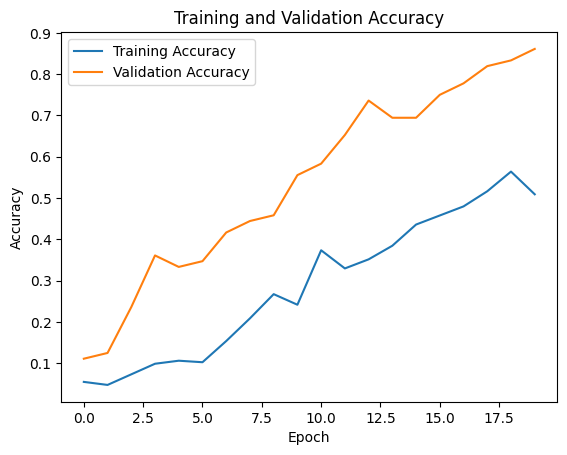

Model berhasil disimpan sebagai 'Amin_model.keras'!


In [24]:
# ==========================
# 5. Evaluasi Model
# ==========================
import matplotlib.pyplot as plt # type: ignore

# Evaluasi Model pada Data Uji
test_loss, test_accuracy = model.evaluate(test_generator)
# Menampilkan Akurasi dalam Bentuk Persentase
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
# Plot akurasi
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Simpan model
model.save("Amin_model.keras")
print("Model berhasil disimpan sebagai 'Amin_model.keras'!")
